multivariate times series, 
regular times series, 
var model et non arima, 
verifier si stationnary, 
use referencing if not, 
todo : dans le "pd.to_datetime(data_raw['timestamp'])" mettre "B" pour business day





In [1]:
#importing the libraries
import numpy as np
import math
import pandas as pd
from datetime import datetime, timedelta, time
from vacances_scolaires_france import SchoolHolidayDates
import sys
from impyute.imputation.cs import mice
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.plotting import autocorrelation_plot
import functools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
import seaborn as sns
#pip install vacances-scolaires-france
#pip install stldecompose
#pip3 install impyute
#pip install statsmodels
#conda install -c conda-forge fbprophet
# my fonctions
def conv(data):
    data["date"] = data.timestamp.apply(lambda x : x.split('T')[0])
    data["datetime_perso"] = data.timestamp.apply(lambda x : get_format_the_date(x))
    data['year']=data['datetime_perso'].dt.year
    data['month']=data['datetime_perso'].dt.month
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hours'] = data['timestamp'].dt.hour
    return data

## get season
def get_season(doy):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if doy in spring:
        season = 'spring'
    elif doy in summer:
      season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

## verifie si jour ferie
def easter_date(year):
    a = year // 100
    b = year % 100
    c = (3 * (a + 25)) // 4
    d = (3 * (a + 25)) % 4
    e = (8 * (a + 11)) // 25
    f = (5 * a + b) % 19
    g = (19 * f + c - e) % 30
    h = (f + 11 * g) // 319
    j = (60 * (5 - d) + b) // 4
    k = (60 * (5 - d) + b) % 4
    m = (2 * j - k - g + h) % 7
    n = (g - h + m + 114) // 31
    p = (g - h + m + 114) % 31
    day = p + 1
    month = n
    return datetime(year, month, day)

def is_ferie(the_date):
    year = the_date.year
    easter = easter_date(year)
    days = [
        datetime(year, 1, 1),  # Premier de l'an
        easter + timedelta(days=1),  # Lundi de Pâques
        datetime(year, 5, 1),  # Fête du Travail
        datetime(year, 5, 8),  # Victoire de 1945
        easter + timedelta(days=39),  # Ascension
        easter + timedelta(days=49),  # Pentecôte
        datetime(year, 7, 14),  # Fête Nationale
        datetime(year, 8, 15),  # Assomption
        datetime(year, 11, 1),  # Toussaint
        datetime(year, 11, 11),  # Armistice 1918
        datetime(year, 12, 25),  # Noël
    ]
    return the_date in days

def get_format_the_date(timestamp):
    do = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f')
    d5 = do.replace(minute=0, hour=0, second=0, microsecond=0).isoformat(' ')
    the_date = datetime.strptime(d5, "%Y-%m-%d %H:%M:%S")
    return the_date

def business_day(timestamp):
    if not is_ferie(timestamp) and timestamp.isoweekday() not in [6, 7]:
        return True
    else:
        return False
    
  

In [2]:
# Creating the test for stationarity
def test_stationarity(timeseries):
    """
    Check stationarity using ADF test
    Ho : The series is non-stationary and has a unit root --> p-value > 0.05
    H1 : The series is stationary and does not have a unit root --> p-value < 0.05
    """
   
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    print('***   {}  *** Running ADF Stationarity test'.format(timeseries.name))
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
   
    if dftest[4]['5%'] > dftest[0]:
        conclusion = 'Series is Stationary @95% CI'
        print ('\t Conclusion: Series is stationary at 95% CI\n')
    elif dftest[4]['10%'] > dftest[0]:
        conclusion = 'Series is Stationary @90% CI'
        print ('\t Conclusion: Series is stationary at 90% CI but non-stationary at 95% CI\n')
    else:
        conclusion = 'Series is non-Stationary'
        print ('\t Conclusion: Series is non-stationary\n')
    return conclusion


In [3]:
#Summary Statistics
def check_summary(series):
    """
    Split the series into two and check summary statistics for both the series
    """
    
    X = series.values
    split =int( len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    meanoverall, mean1, mean2 = X.mean(), X1.mean(), X2.mean()
    varoverall, var1, var2 = X.var(), X1.var(), X2.var()
    print('mean overall = %f, \t mean1=%f, \t mean2=%f' % (meanoverall, mean1, mean2))
    print('variance overall= %f, \t variance1=%f, \t variance2=%f' % (varoverall, var1, var2))


#Distribution by plotting Histogram
def check_distribution(series):
    """
    Distribution by plotting Histogram
    """
    series.hist()
    plt.show()        

#Series Plots:
def check_plots(series):
    """
    Plots the series as a line chart
    """
    plt.plot(series)
    plt.show()        
    
def check_normality(series):
    result = stats.normaltest(series)
    
    print('Test: Running Agostino and Pearson Normality test for {} \n\t Normality test statistic: {} \n\t p-value: {} '.format(series.name, result[0], result[1]))
    
    if(result[1]< 0.05):
        conclusion = 'Not Normally Distributed'
        print('\t Conclusion: {} is not normally distributed at 95% CI \n'.format(series.name))
    else:
        conclusion = 'Normally Distributed'
        print('\t Conclusion: {} is normally distributed at 95% CI \n'.format(series.name))
        
    return conclusion 

In [4]:
def processing(dataInt):
    ## missing value
    df = dataInt.copy()
    #df_num = df.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    #df_NonNum = df.select_dtypes(include=[np.object])
    imputed_training_mice = mice(df.values)
    data_mice = pd.DataFrame(imputed_training_mice, columns = df.columns, index = list(df.index.values))
   # dClean = data_mice.join(df_NonNum)
    ## drop variable inutile
    #d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    ## create extra attribute
    #conv(d_tr)
    #d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
    ## create season and rangeInYear
    #s = pd.to_datetime(pd.Series(d_tr['timestamp']))
    #d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
    #create jours working days
   # d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
    #Is it an holiday for zone A, B or C?
    #d = SchoolHolidayDates()
    #d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
    #d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
    #dataInt1 = d_tr.drop(['rangeInYear', 'datetime_perso', 'date', 'timestamp'], axis=1)
    return (data_mice)  


--------------------------------------------------------------------------------------------------------------------

In [5]:
# creere un je
dataInt_raw = pd.read_csv('./data_set1/input_training_ssnsrY0.csv')
dataOut_raw = pd.read_csv('./data_set1/output_training_Uf11I9I.csv')
data_raw = pd.concat([dataInt_raw, dataOut_raw], axis=1)
data_raw.head()
data_raw.columns
#----------------------


Index(['ID', 'timestamp', 'temp_1', 'temp_2', 'mean_national_temp',
       'humidity_1', 'humidity_2', 'loc_1', 'loc_2', 'loc_secondary_1',
       'loc_secondary_2', 'loc_secondary_3', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_secondary_3', 'ID',
       'consumption_1', 'consumption_2'],
      dtype='object')

In [6]:
df = data_raw.loc[:, ['temp_1', 'temp_2','mean_national_temp', 'humidity_1', 'humidity_2', 
                              'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3','consumption_1','consumption_2']]


In [7]:
df.describe()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
count,8589.000000,8429.000000,8760.000000,8589.000000,8428.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.402771,15.086274,13.173858,77.351496,63.443284,203.025114,123.581735,235.774201,137.549543,148.529909
std,7.049919,8.463627,6.474700,16.638173,21.900343,69.792811,65.036526,99.701896,63.146689,73.263972
min,-5.700000,-7.200000,-1.800000,21.000000,12.000000,84.000000,0.000000,94.000000,38.000000,0.000000
25%,6.100000,9.000000,8.200000,66.000000,46.000000,150.000000,73.000000,166.000000,91.000000,105.000000
50%,11.200000,14.500000,12.800000,81.000000,65.000000,181.000000,107.000000,194.000000,116.000000,129.000000
75%,16.400000,21.000000,18.700000,91.000000,83.000000,252.000000,160.000000,287.250000,176.000000,181.000000
max,33.600000,39.300000,28.300000,100.000000,99.000000,464.000000,355.000000,570.000000,349.000000,542.000000


In [8]:
df = processing(df)

In [9]:
df.shape

(8760, 10)

In [10]:
df.dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
consumption_1              float64
consumption_2              float64
dtype: object

In [11]:
df.columns

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 10 columns):
temp_1                     8760 non-null float64
temp_2                     8760 non-null float64
mean_national_temp         8760 non-null float64
humidity_1                 8760 non-null float64
humidity_2                 8760 non-null float64
consumption_secondary_1    8760 non-null float64
consumption_secondary_2    8760 non-null float64
consumption_secondary_3    8760 non-null float64
consumption_1              8760 non-null float64
consumption_2              8760 non-null float64
dtypes: float64(10)
memory usage: 752.8 KB


In [13]:
# Providing the index to the time series
df = pd.DataFrame(data = df.values,
                   columns = df.columns,
                   index = pd.date_range(start = '2016-11-01 00:00:00', 
                                                 periods = 8760, 
                                                 freq = 'H'))

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2016-11-01 00:00:00 to 2017-10-31 23:00:00
Freq: H
Data columns (total 10 columns):
temp_1                     8760 non-null float64
temp_2                     8760 non-null float64
mean_national_temp         8760 non-null float64
humidity_1                 8760 non-null float64
humidity_2                 8760 non-null float64
consumption_secondary_1    8760 non-null float64
consumption_secondary_2    8760 non-null float64
consumption_secondary_3    8760 non-null float64
consumption_1              8760 non-null float64
consumption_2              8760 non-null float64
dtypes: float64(10)
memory usage: 752.8 KB


In [15]:
df.head(2)

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
2016-11-01 00:00:00,8.3,11.188715,11.1,95.0,75.378744,143.0,74.0,168.0,100.0,93.0
2016-11-01 01:00:00,8.0,10.805618,11.1,98.0,76.908299,141.0,60.0,162.0,101.0,94.0


In [16]:
df.dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
consumption_1              float64
consumption_2              float64
dtype: object

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


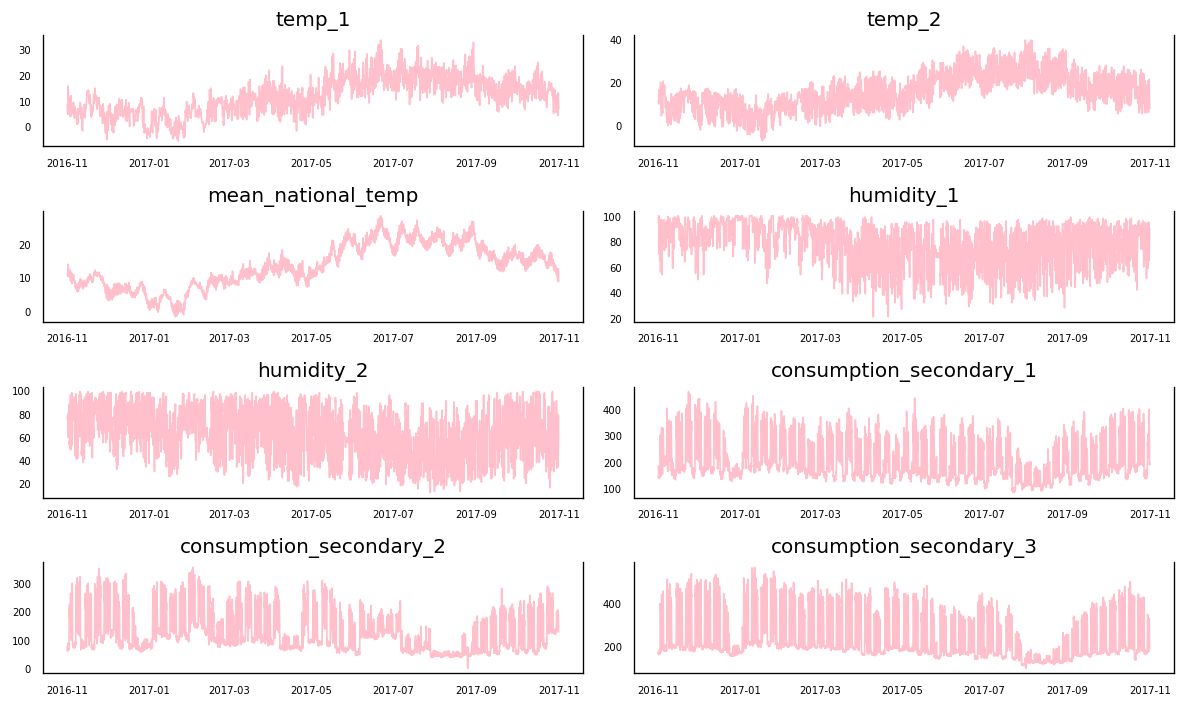

In [18]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='pink', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## CHECK STATIONARITY


In [19]:
# Loop to check all columns of the DF

df.apply(functools.partial(test_stationarity))

Results of Dickey-Fuller Test:
***   temp_1  *** Running ADF Stationarity test
Test Statistic                   -3.568133
p-value                           0.006400
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   temp_2  *** Running ADF Stationarity test
Test Statistic                   -3.377898
p-value                           0.011736
#Lags Used                       33.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   mean_national_temp  *** Running ADF Stationarity test
Test Statistic             

temp_1                     Series is Stationary @95% CI
temp_2                     Series is Stationary @95% CI
mean_national_temp             Series is non-Stationary
humidity_1                 Series is Stationary @95% CI
humidity_2                 Series is Stationary @95% CI
consumption_secondary_1    Series is Stationary @95% CI
consumption_secondary_2    Series is Stationary @95% CI
consumption_secondary_3    Series is Stationary @95% CI
consumption_1              Series is Stationary @95% CI
consumption_2              Series is Stationary @95% CI
dtype: object

c/c : todo remove  mean_national_temp: Series is non-stationary.******* se pose la question, si une variable non_stationary, est ce que je dois differencing all the columns? 

In [20]:
df3 = df.drop(['mean_national_temp'], axis=1)

In [21]:
df3.head(2)

,temp_1,temp_2,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
2016-11-01 00:00:00,8.3,11.188715,95.0,75.378744,143.0,74.0,168.0,100.0,93.0
2016-11-01 01:00:00,8.0,10.805618,98.0,76.908299,141.0,60.0,162.0,101.0,94.0


quid de la sesonality? esssayer avec et aussi remove seasonality 

In [22]:
# seasonal decompsition

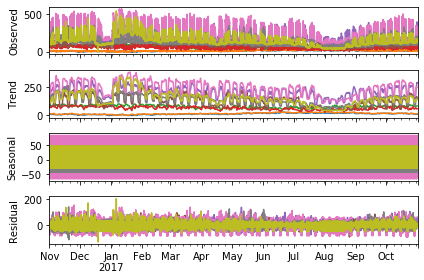

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from stldecompose import decompose
# Simple seasonal decomposition
decomposed = seasonal_decompose(df3)
dplot = decomposed.plot()


In [24]:
df3adjudested = df3 - decomposed.seasonal

In [25]:
df3adjudested.apply(functools.partial(test_stationarity))

Results of Dickey-Fuller Test:
***   temp_1  *** Running ADF Stationarity test
Test Statistic                   -3.423555
p-value                           0.010182
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   temp_2  *** Running ADF Stationarity test
Test Statistic                   -3.146888
p-value                           0.023272
#Lags Used                       33.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   humidity_1  *** Running ADF Stationarity test
Test Statistic                -6.79

temp_1                     Series is Stationary @95% CI
temp_2                     Series is Stationary @95% CI
humidity_1                 Series is Stationary @95% CI
humidity_2                 Series is Stationary @95% CI
consumption_secondary_1    Series is Stationary @95% CI
consumption_secondary_2    Series is Stationary @95% CI
consumption_secondary_3    Series is Stationary @95% CI
consumption_1              Series is Stationary @95% CI
consumption_2              Series is Stationary @95% CI
dtype: object

In [26]:
df3adjudested.shape

(8760, 9)

In [27]:
df3AdjDiff = df3adjudested.diff().dropna()
df3AdjDiff.head(2)

,temp_1,temp_2,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
2016-11-01 01:00:00,0.047173,0.185046,1.404640,-0.577086,-1.792983,-8.655792,-3.495478,1.775298,0.979167
2016-11-01 02:00:00,-0.904907,0.275233,-2.468621,-1.188135,1.220066,1.816678,2.707704,-0.518143,2.153503


In [28]:
df3AdjDiff.apply(functools.partial(test_stationarity))

Results of Dickey-Fuller Test:
***   temp_1  *** Running ADF Stationarity test
Test Statistic                  -19.113472
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   temp_2  *** Running ADF Stationarity test
Test Statistic                  -19.942654
p-value                           0.000000
#Lags Used                       32.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   humidity_1  *** Running ADF Stationarity test
Test Statistic                  -21

temp_1                     Series is Stationary @95% CI
temp_2                     Series is Stationary @95% CI
humidity_1                 Series is Stationary @95% CI
humidity_2                 Series is Stationary @95% CI
consumption_secondary_1    Series is Stationary @95% CI
consumption_secondary_2    Series is Stationary @95% CI
consumption_secondary_3    Series is Stationary @95% CI
consumption_1              Series is Stationary @95% CI
consumption_2              Series is Stationary @95% CI
dtype: object

In [34]:
model = VAR(df3AdjDiff)

In [35]:
results = model.fit(maxlags=30, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Jul, 2019
Time:                     21:26:59
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    28.6018
Nobs:                     8734.00    HQIC:                   27.5157
Log likelihood:          -227212.    FPE:                5.08281e+11
AIC:                      26.9542    Det(Omega_mle):     4.03878e+11
--------------------------------------------------------------------
Results for equation temp_1
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.000332         0.007165           -0.046           0.963
L1.temp_1                           0.271574         0.013833           19.632           0.000
L1.

In [36]:
df3AdjDiff.columns

Index(['temp_1', 'temp_2', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

In [37]:
grangres = results.test_causality(['consumption_2', 'consumption_secondary_3', 'temp_1', 'temp_2',
       'humidity_1', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_1'], [ 'humidity_2'], kind='f')
grangres.summary()

Test statistic,Critical value,p-value,df
1.453,1.170,0.000,"(200, 76572)"


<Figure size 864x720 with 0 Axes>

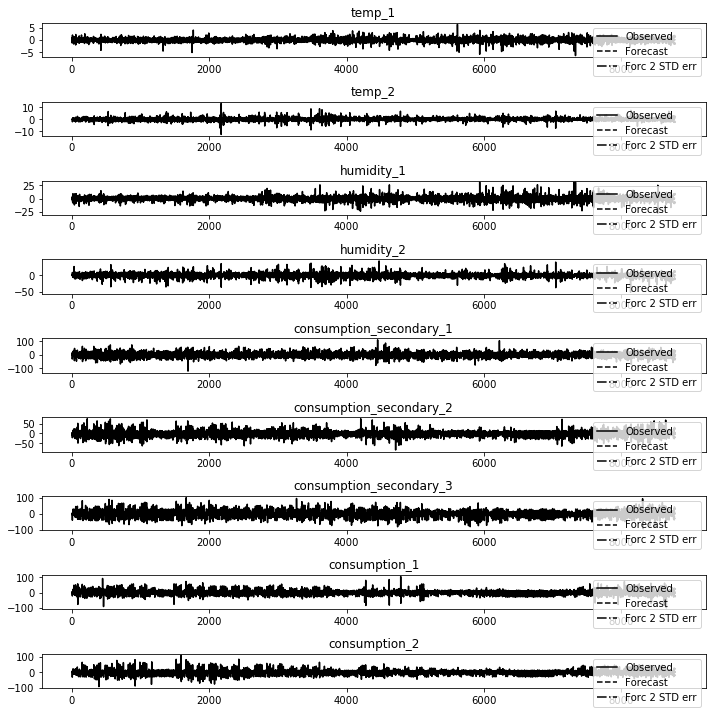

In [47]:
plt.figure(figsize = (12, 10))
results.plot_forecast(30)
plt.tight_layout(h_pad = 1.15)
plt.show()

In [48]:
fcast = results.forecast(df3adjudested.values, 30)

In [49]:
pd.DataFrame(pd.DataFrame(df3adjudested).head(10))

,temp_1,temp_2,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
2016-11-01 00:00:00,9.822252,14.271393,89.336793,64.186444,185.098171,103.552229,229.387189,140.838871,121.686470
2016-11-01 01:00:00,9.869425,14.456438,90.741433,63.609358,183.305188,94.896437,225.891710,142.614168,122.665636
2016-11-01 02:00:00,8.964518,14.731671,88.272812,62.421223,184.525255,96.713115,228.599414,142.096025,124.819139
2016-11-01 03:00:00,9.915823,14.842628,89.317463,61.903298,180.854582,96.387565,226.478649,143.413276,123.405506
2016-11-01 04:00:00,8.755670,15.015261,87.460830,61.243323,195.273538,95.037004,227.762246,142.518472,128.021921
2016-11-01 05:00:00,8.235743,14.987363,86.718801,60.776540,204.652830,88.577755,225.791206,134.970911,135.390167
2016-11-01 06:00:00,7.806100,14.776556,87.606164,62.568380,180.158325,91.151702,214.027928,127.957689,117.655449
2016-11-01 07:00:00,7.555662,14.135787,88.740006,65.458031,148.302956,72.325924,184.996163,130.239683,85.603938
2016-11-01 08:00:00,6.418845,12.151624,91.113277,72.043435,120.438659,50.525157,144.704897,107.854839,68.848787
2016-11-01 09:00:00,6.321235,10.064683,95.603183,80.309792,101.655406,44.795990,107.630721,99.470510,61.728365


In [50]:
cons1values = pd.DataFrame(df3adjudested.consumption_1)

In [51]:
cons1values.head(2)

,consumption_1
2016-11-01 00:00:00,140.838871
2016-11-01 01:00:00,142.614168


In [52]:
df3adjudested.tail(1)

,temp_1,temp_2,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
2017-10-31 23:00:00,8.114092,10.372249,86.095762,69.202301,239.884401,155.943941,245.395316,165.384544,145.445971


In [53]:
DeDiff = np.cumsum(cons1values) + 165.384544

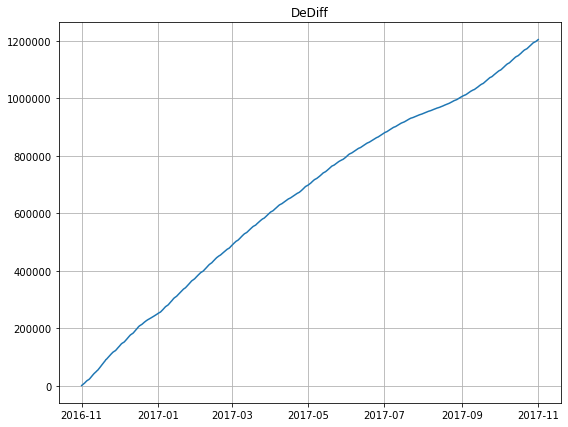

In [54]:
plt.figure(figsize = (9,7))
plt.plot(DeDiff)
plt.title('DeDiff')
plt.grid()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=2
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [ ]:
grangers_causation_matrix(df3adjudested, variables = df3adjudested.columns)    

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [ ]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df1)

In [ ]:
#split
nobs = 292
df1_train, df1_test = df1[0:-nobs], df1[-nobs:]

# Check size
print(df1_train.shape)  # (8468, 8)()
print(df1_test.shape)  # 292, 8)

In [ ]:
df1_train.index

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':r[0], 'pvalue':r[1],  'n_lags':r[2], 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 5)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   
          
         

In [ ]:
# ADF Test on each column
for name, column in df1_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
df1_differenced = df1_train.diff(366).dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df1_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
df1_train.head()

In [ ]:
df1_differenced.head()

In [ ]:
model = VAR(df1_differenced)

In [ ]:
model.select_order(30)

In [ ]:
res= model.fit(maxlags=15, ic='aic')

In [ ]:
res.summary()

In [ ]:
res.plot_acorr()

In [ ]:

for i in [1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

In [ ]:
x = model.select_order(maxlags=37)
x.summary()

In [ ]:
model_fitted = model.fit(28)
model_fitted.summary()

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

Durbin Watson Statistic - Formula

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson


In [ ]:
out = durbin_watson(model_fitted.resid)

In [ ]:
for col, val in zip(df1.columns, out):
    print(col, ':', round(val, 2))

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

In [ ]:
# Input data for forecasting
forecast_input = df1_differenced.values[-lag_order:]
forecast_input

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df1_train, df_forecast, second_diff=False)
df_results.columns

In [ ]:
df_results.loc[:,[ 'temp_1_forecast',
       'temp_2_forecast', 'mean_national_temp_forecast', 'humidity_1_forecast',
       'humidity_2_forecast', 'consumption_secondary_1_forecast',
       'consumption_secondary_2_forecast', 'consumption_secondary_3_forecast',
       'consumption_1_forecast', 'consumption_2_forecast']]

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df1.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df1.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df1_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: temp_1')
accuracy_prod = forecast_accuracy(df_results['temp_1_forecast'].values, df1_test['temp_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: temp_2')
accuracy_prod = forecast_accuracy(df_results['temp_2_forecast'].values, df1_test['temp_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: mean_national_temp')
accuracy_prod = forecast_accuracy(df_results['mean_national_temp_forecast'].values, df1_test['mean_national_temp'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
print('\nForecast Accuracy of: humidity_1')
accuracy_prod = forecast_accuracy(df_results['humidity_1_forecast'].values, df1_test['humidity_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: humidity_2')
accuracy_prod = forecast_accuracy(df_results['humidity_2_forecast'].values, df1_test['humidity_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_secondary_1')
accuracy_prod = forecast_accuracy(df_results['consumption_secondary_1_forecast'].values, df1_test['consumption_secondary_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_secondary_2')
accuracy_prod = forecast_accuracy(df_results['consumption_secondary_2_forecast'].values, df1_test['consumption_secondary_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_secondary_3')
accuracy_prod = forecast_accuracy(df_results['consumption_secondary_3_forecast'].values, df1_test['consumption_secondary_3'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_1')
accuracy_prod = forecast_accuracy(df_results['consumption_1_forecast'].values, df1_test['consumption_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_2')
accuracy_prod = forecast_accuracy(df_results['consumption_2_forecast'].values, df1_test['consumption_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))